In [ ]:
%pip install git+https://github.com/vladkens/twscrape.git
%pip install langdetect

Functions to clean the contents of the tweet

In [2]:
import re
import html
def clean_tweet_content(text):
    """Remove mentions, links, emojis, newlines, and specific search terms from tweet text."""
    text = html.unescape(text)
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\n+', ' ', text)  # Replace newlines with space
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\$\w+', '', text)  # Remove cashtags

    # Remove emojis
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"
                                u"\U0001F300-\U0001F5FF"
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F1E0-\U0001F1FF"
                                u"\U0001F700-\U0001F77F"
                                u"\U0001F780-\U0001F7FF"
                                u"\U0001F800-\U0001F8FF"
                                u"\U0001F900-\U0001F9FF"
                                u"\U0001FA00-\U0001FA6F"
                                u"\U0001FA70-\U0001FAFF"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  # Apply regex to remove emojis
    
    # Normalize spaces - replace two or more spaces with a single space
    text = re.sub(r'\s{2,}', ' ', text)

    return text.strip()

def is_gibberish(text):
    # Define a list of promotional phrases to search for
    promotional_phrases = [
        "join us",
        "find out more",
        "Sign up now",
        "become a member",
        "Subscribe for updates",
        "Limited time offer",
        "Exclusive access",
        "Free trial",
        "Don't miss out",
        "Last chance",
        "Early bird discount",
        "Save big",
        "Register today",
        "Unlock benefits",
        "Special promotion",
        "Available for a limited time",
        "Claim your offer",
        "Act now",
        "Exclusive deals",
        "Get started",
        "Offer ends soon",
        "While supplies last",
        "Money-back guarantee",
        "Check out now"
        "Check out"
    ]
    
    # Create a combined regular expression from the list of phrases
    regex_pattern = '|'.join(map(re.escape, promotional_phrases))
    # Search for any of the phrases in the text
    contains_promotion = re.search(regex_pattern, text, re.IGNORECASE) is not None

    # _________________________________________________________________________________
    
    # A simple heuristic: check if the text has at least three alphabetic characters
    is_gibberish = len(re.findall("[a-zA-Z]", text)) < 3
    
    return  contains_promotion or is_gibberish

Get Tweets from Twitter

In [3]:
st_search_term = "Tesla OR TSLA"
ticker="TSLA"
tweets_limit=30

In [4]:
from twscrape import API, gather
from twscrape.logger import set_log_level
import json
import time
from langdetect import detect, LangDetectException
import re


# ####################################################################################
# Gather the tweets
# ####################################################################################
async def main():
    api = API()  # or API("path-to.db") - default is `accounts.db`

    # ADD ACCOUNTS (for CLI usage see BELOW)
    await api.pool.add_account("DarOho4050", "asdfghjkl1!", "we444465@gmail.com", "mail_pass1")
    await api.pool.login_all()

# search (latest tab)
    tweets = await gather(api.search(st_search_term, limit=tweets_limit))  # list[Tweet]
    print(tweets)
    
    def user_to_dict(user):
        return {
            'id': user.id,
            'id_str': user.id_str,
            'url': user.url,
            'username': user.username,
            'displayname': user.displayname,
            'rawDescription': user.rawDescription,
            'created': user.created.isoformat() if user.created else None,            
        }
    
    def tweet_to_dict(tweet):
        return {
            'id': tweet.id,
            'date': tweet.date.isoformat(),
            'rawContent': tweet.rawContent,
            'cleanContent': clean_tweet_content(tweet.rawContent),
            'url': tweet.url,
            'user': user_to_dict(tweet.user),
            'lang': tweet.lang,
            'replyCount': tweet.replyCount,
            'retweetCount': tweet.retweetCount,
            'likeCount': tweet.likeCount,
            'quoteCount': tweet.quoteCount
        }

    # Convert each Tweet instance to a dictionary
    tweets_as_dicts = [tweet_to_dict(tweet) for tweet in tweets]
    print(tweets_as_dicts)
    return tweets_as_dicts
    
def write_tweets_to_file(tweets, file_path):
    """Generic function to write tweets to a specified file with deduplication."""
    new_tweets_count = 0
    existing_ids = set()
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            existing_ids.update(json.loads(line)['id'] for line in file)
    except FileNotFoundError:
        pass  # It's okay if the file does not exist yet

    with open(file_path, 'a', encoding='utf-8') as file:
        for tweet in tweets:
            if tweet['id'] not in existing_ids:
                file.write(json.dumps(tweet, ensure_ascii=False) + '\n')
                new_tweets_count += 1
                existing_ids.add(tweet['id'])

    return new_tweets_count

def does_tweet_match_criteria(tweet_content, search_terms):
    """Check if tweet content matches the search criteria using regex for flexibility.
       Supports 'AND' and 'OR' logic in search terms."""
    # Split the search terms based on 'AND' and 'OR' logic
    or_groups = [group.strip() for group in search_terms.split('OR')]
    
    for group in or_groups:
        # For each 'OR' group, check if any of the 'AND' terms are all present
        and_terms = group.split('AND')
        if all(re.search(r'\b' + term.strip() + r'\b', tweet_content, re.IGNORECASE) for term in and_terms):
            return True  # If all 'AND' terms in any 'OR' group match, return True
    return False  # If none of the groups match, return False

def filter_tweets(tweets, search_term, language="en"):
    """Filter out Tweets that do not contain all of the provided search terms."""
    english_tweets = []
    filtered_tweets = []  # Tweets filtered out
    for tweet in tweets:
        if does_tweet_match_criteria(tweet['rawContent'], search_term):
            try:
                if detect(tweet['cleanContent']) == 'en' and not is_gibberish(tweet['cleanContent']):
                    english_tweets.append(tweet)
                else:
                    filtered_tweets.append(tweet)
            except LangDetectException:
                # Assume English if detection fails
                filtered_tweets.append(tweet)
    return english_tweets, filtered_tweets

async def main_tweets():
    tweets = await main()  # Assume this fetches a list of tweet dictionaries
    english_tweets, filtered_tweets = filter_tweets(tweets, st_search_term)
    
    new_english_count = write_tweets_to_file(english_tweets, f'{ticker}_tweets.jsonl')
    filtered_count = write_tweets_to_file(filtered_tweets, f'filtered_{ticker}_tweets.jsonl')
    
    total_processed = len(english_tweets) + len(filtered_tweets)
    
    if total_processed > 0:
        english_percentage = (new_english_count / total_processed) * 100
        filtered_percentage = (filtered_count / total_processed) * 100
        print(f"Processed {total_processed} tweets. New English: {english_percentage:.2f}%. Filtered: {filtered_percentage:.2f}%.")
    else: 
        print("No tweets to process.")
    

Get Tweets from StockTwits

In [5]:
# !git clone https://github.com/AI4Finance-Foundation/FinNLP.git
# Stocktwits
import sys
sys.path.append(r'C:\Users\bow33\Documents\GitHub\stocktwits-sentiment\FinNLP')
from finnlp.data_sources.social_media.stocktwits_streaming import Stocktwits_Streaming

st_search_term = f"{ticker}"
file_path = f'./{ticker}_stocktwits.jsonl'


pages = 1
config = {
    "max_retry": 5
}

async def main_stocktwits():
    downloader = Stocktwits_Streaming(config)
    downloader.download_streaming_stock(ticker, pages)

    stocktweets = downloader.dataframe
    stocktweets = stocktweets.rename(columns={'body': 'rawContent'})
    stocktweets = stocktweets.to_dict('records')
    # print(stocktweets)

    stocktweets = [{**tweet, 'cleanContent': clean_tweet_content(tweet['rawContent'])} for tweet in stocktweets]

    english_tweets, filtered_tweets = filter_tweets(stocktweets, st_search_term)

    new_english_count = write_tweets_to_file(english_tweets, f'{ticker}_stocktweets.jsonl')
    filtered_count = write_tweets_to_file(filtered_tweets, f'filtered_{ticker}_stocktweets.jsonl')

    total_processed = len(english_tweets) + len(filtered_tweets)

    if total_processed > 0:
        english_percentage = (new_english_count / total_processed) * 100
        filtered_percentage = (filtered_count / total_processed) * 100
        print(f"Processed {total_processed} stocktwits. New English: {english_percentage:.2f}%. Filtered: {filtered_percentage:.2f}%.")
    else: 
        print("No tweets to process.")

C:\Users\bow33\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Run both at the same time (indefinity every 60 seconds)

In [6]:
while True:
    await main_tweets()
    await main_stocktwits()
    time.sleep(60)  # Sleep for x seconds

2024-02-14 05:40:55.563 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757641029216535018, id_str='1757641029216535018', url='https://twitter.com/levandovsky/status/1757641029216535018', date=datetime.datetime(2024, 2, 14, 5, 40, 51, tzinfo=datetime.timezone.utc), user=User(id=31052410, id_str='31052410', url='https://twitter.com/levandovsky', username='levandovsky', displayname='Roman Levandovsky 🇺🇦 🇮🇱', rawDescription='Omnem Movere Lapidem. Sports entrepreneur. Hockey is life!', created=datetime.datetime(2009, 4, 14, 4, 1, 29, tzinfo=datetime.timezone.utc), followersCount=569, friendsCount=349, statusesCount=17633, favouritesCount=29761, listedCount=13, mediaCount=859, location='Calgary, AB', profileImageUrl='https://pbs.twimg.com/profile_images/734944770351468544/ldZuAHoU_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/31052410/1685162384', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[TextLink(url='http://www.linkedin.com/profile?viewProfile=&key=1417379&locale=en_US&trk=tab_pro', text='li

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Processed 30 stocktwits. New English: 86.67%. Filtered: 13.33%.


2024-02-14 05:41:59.834 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757641308376563720, id_str='1757641308376563720', url='https://twitter.com/SecEpstein/status/1757641308376563720', date=datetime.datetime(2024, 2, 14, 5, 41, 57, tzinfo=datetime.timezone.utc), user=User(id=1742715490319978496, id_str='1742715490319978496', url='https://twitter.com/SecEpstein', username='SecEpstein', displayname='Secretary Jeffrey Epstein', rawDescription='Proud to be serving my second term with the Hillary Clinton Administration after defeating the EVIL Orange Man in 2016 🇺🇸', created=datetime.datetime(2024, 1, 4, 1, 12, 22, tzinfo=datetime.timezone.utc), followersCount=7, friendsCount=24, statusesCount=68, favouritesCount=218, listedCount=0, mediaCount=1, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1742716350856933376/lT-S76u4_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1742715490319978496/1704335087', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitt

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:43:03.108 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757641537901773051, id_str='1757641537901773051', url='https://twitter.com/tartarremoval/status/1757641537901773051', date=datetime.datetime(2024, 2, 14, 5, 42, 52, tzinfo=datetime.timezone.utc), user=User(id=1393006975047241728, id_str='1393006975047241728', url='https://twitter.com/tartarremoval', username='tartarremoval', displayname='치석제거𝕏', rawDescription='테슬라 투자자, 전직 준비 중인 직장인 I will not let you down, no matter what it takes.', created=datetime.datetime(2021, 5, 14, 0, 55, 22, tzinfo=datetime.timezone.utc), followersCount=1903, friendsCount=633, statusesCount=11296, favouritesCount=63709, listedCount=13, mediaCount=1284, location='South Korea', profileImageUrl='https://pbs.twimg.com/profile_images/1675108125878403072/YRS0l0D5_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1393006975047241728/1688211934', protected=None, verified=False, blue=True, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='ko', rawContent='@Fu

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:44:06.969 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757641717598298573, id_str='1757641717598298573', url='https://twitter.com/AndyAnagnostou/status/1757641717598298573', date=datetime.datetime(2024, 2, 14, 5, 43, 35, tzinfo=datetime.timezone.utc), user=User(id=1342521082289373185, id_str='1342521082289373185', url='https://twitter.com/AndyAnagnostou', username='AndyAnagnostou', displayname='Andrew Anagnostou', rawDescription='Sports fan ⛳️🏈🏀 Financial Markets 🇺🇸🇺🇸', created=datetime.datetime(2020, 12, 25, 17, 22, 53, tzinfo=datetime.timezone.utc), followersCount=13, friendsCount=730, statusesCount=748, favouritesCount=3540, listedCount=1, mediaCount=3, location='San Carlos, CA', profileImageUrl='https://pbs.twimg.com/profile_images/1342539569934176258/iFG0pGUv_normal.jpg', profileBannerUrl=None, protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='@iamtomnash Jonas from MS just cut price target to 345 from 380. $TSLA', replyCount=0, ret

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:45:10.276 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757642102031401120, id_str='1757642102031401120', url='https://twitter.com/AshwinTrades1/status/1757642102031401120', date=datetime.datetime(2024, 2, 14, 5, 45, 7, tzinfo=datetime.timezone.utc), user=User(id=1633600242510860288, id_str='1633600242510860288', url='https://twitter.com/AshwinTrades1', username='AshwinTrades1', displayname='Ashwin', rawDescription='Trader | Entrepreneur', created=datetime.datetime(2023, 3, 8, 22, 50, 3, tzinfo=datetime.timezone.utc), followersCount=231, friendsCount=33, statusesCount=1319, favouritesCount=141, listedCount=2, mediaCount=701, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1698006313492758528/WBzFciKT_normal.jpg', profileBannerUrl=None, protected=None, verified=False, blue=True, blueType=None, descriptionLinks=[TextLink(url='https://linktr.ee/ashwinsullia', text='linktr.ee/ashwinsullia', tcourl='https://t.co/xIOvx74hoC')], _type='snscrape.modules.twitter.User'), lang='en', rawContent='Daily Market Analysis 📈\n\n

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:46:13.281 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757642329219854561, id_str='1757642329219854561', url='https://twitter.com/niccruzpatane/status/1757642329219854561', date=datetime.datetime(2024, 2, 14, 5, 46, 1, tzinfo=datetime.timezone.utc), user=User(id=1494873435863977985, id_str='1494873435863977985', url='https://twitter.com/niccruzpatane', username='niccruzpatane', displayname='Nic Cruz Patane', rawDescription='Deep dive into everything Tesla | The future is now', created=datetime.datetime(2022, 2, 19, 3, 16, 24, tzinfo=datetime.timezone.utc), followersCount=4615, friendsCount=94, statusesCount=8540, favouritesCount=6630, listedCount=46, mediaCount=2945, location='Toronto, CA', profileImageUrl='https://pbs.twimg.com/profile_images/1702417767129858048/XfXuuN9b_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1494873435863977985/1700667743', protected=None, verified=False, blue=True, blueType=None, descriptionLinks=[TextLink(url='https://ts.la/nicolas76081', text='ts.la/nicolas76081', tcourl='https

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Processed 30 stocktwits. New English: 3.33%. Filtered: 0.00%.


2024-02-14 05:47:16.428 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757642633705660777, id_str='1757642633705660777', url='https://twitter.com/TeslaFUDL/status/1757642633705660777', date=datetime.datetime(2024, 2, 14, 5, 47, 13, tzinfo=datetime.timezone.utc), user=User(id=1672255174021357571, id_str='1672255174021357571', url='https://twitter.com/TeslaFUDL', username='TeslaFUDL', displayname='TeslaFUDL', rawDescription='Longtime $TSLA investor, Sold house and is up 100X', created=datetime.datetime(2023, 6, 23, 14, 48, 19, tzinfo=datetime.timezone.utc), followersCount=995, friendsCount=172, statusesCount=8227, favouritesCount=4171, listedCount=17, mediaCount=1484, location='United States ', profileImageUrl='https://pbs.twimg.com/profile_images/1757029868649512960/4jlV9Pe6_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1672255174021357571/1707722222', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='@mark_prati Bro.\n\nElon shado

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:48:19.874 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757642893085360494, id_str='1757642893085360494', url='https://twitter.com/RAJURAY48184/status/1757642893085360494', date=datetime.datetime(2024, 2, 14, 5, 48, 15, tzinfo=datetime.timezone.utc), user=User(id=1353211811638751234, id_str='1353211811638751234', url='https://twitter.com/RAJURAY48184', username='RAJURAY48184', displayname='RAJU RAY', rawDescription='Patience and the right analysis can take you to the top.', created=datetime.datetime(2021, 1, 24, 5, 23, 46, tzinfo=datetime.timezone.utc), followersCount=952, friendsCount=0, statusesCount=251593, favouritesCount=0, listedCount=13, mediaCount=249458, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1701271143284621312/lkwMb8Ch_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1353211811638751234/1694448156', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='Guys ! i made 19k after joined t

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:49:22.906 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757643021921681449, id_str='1757643021921681449', url='https://twitter.com/RAJURAY48184/status/1757643021921681449', date=datetime.datetime(2024, 2, 14, 5, 48, 46, tzinfo=datetime.timezone.utc), user=User(id=1353211811638751234, id_str='1353211811638751234', url='https://twitter.com/RAJURAY48184', username='RAJURAY48184', displayname='RAJU RAY', rawDescription='Patience and the right analysis can take you to the top.', created=datetime.datetime(2021, 1, 24, 5, 23, 46, tzinfo=datetime.timezone.utc), followersCount=952, friendsCount=0, statusesCount=251595, favouritesCount=0, listedCount=13, mediaCount=249460, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1701271143284621312/lkwMb8Ch_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1353211811638751234/1694448156', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='📈 Building brick by brick, our a

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:50:26.061 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757643393365098833, id_str='1757643393365098833', url='https://twitter.com/RAJURAY48184/status/1757643393365098833', date=datetime.datetime(2024, 2, 14, 5, 50, 15, tzinfo=datetime.timezone.utc), user=User(id=1353211811638751234, id_str='1353211811638751234', url='https://twitter.com/RAJURAY48184', username='RAJURAY48184', displayname='RAJU RAY', rawDescription='Patience and the right analysis can take you to the top.', created=datetime.datetime(2021, 1, 24, 5, 23, 46, tzinfo=datetime.timezone.utc), followersCount=952, friendsCount=0, statusesCount=251597, favouritesCount=0, listedCount=13, mediaCount=249462, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1701271143284621312/lkwMb8Ch_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1353211811638751234/1694448156', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='🎯Another week went pretty well \

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:51:29.123 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757643577268773108, id_str='1757643577268773108', url='https://twitter.com/tsla_diamond/status/1757643577268773108', date=datetime.datetime(2024, 2, 14, 5, 50, 58, tzinfo=datetime.timezone.utc), user=User(id=1543479558414159874, id_str='1543479558414159874', url='https://twitter.com/tsla_diamond', username='tsla_diamond', displayname='두부아부지야🚙🏕🏥✈️🛀', rawDescription='버티는 자가 이긴다.', created=datetime.datetime(2022, 7, 3, 6, 20, tzinfo=datetime.timezone.utc), followersCount=1533, friendsCount=960, statusesCount=9279, favouritesCount=22973, listedCount=5, mediaCount=660, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1748908227377733632/DhQH3i0w_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1543479558414159874/1692923575', protected=None, verified=False, blue=True, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='qme', rawContent='@solomonit7 😀😀', replyCount=0, retweetCount=0, likeCount=0, quoteCount=0, con

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:52:32.158 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757643877689770010, id_str='1757643877689770010', url='https://twitter.com/RAJURAY48184/status/1757643877689770010', date=datetime.datetime(2024, 2, 14, 5, 52, 10, tzinfo=datetime.timezone.utc), user=User(id=1353211811638751234, id_str='1353211811638751234', url='https://twitter.com/RAJURAY48184', username='RAJURAY48184', displayname='RAJU RAY', rawDescription='Patience and the right analysis can take you to the top.', created=datetime.datetime(2021, 1, 24, 5, 23, 46, tzinfo=datetime.timezone.utc), followersCount=952, friendsCount=0, statusesCount=251601, favouritesCount=0, listedCount=13, mediaCount=249466, location='', profileImageUrl='https://pbs.twimg.com/profile_images/1701271143284621312/lkwMb8Ch_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1353211811638751234/1694448156', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='$QQQ RUNNING PREMARKET. NEWS ART

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:53:36.130 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757644029133492421, id_str='1757644029133492421', url='https://twitter.com/Octonione/status/1757644029133492421', date=datetime.datetime(2024, 2, 14, 5, 52, 46, tzinfo=datetime.timezone.utc), user=User(id=1754870353531129856, id_str='1754870353531129856', url='https://twitter.com/Octonione', username='Octonione', displayname='Octonione', rawDescription='Seeking excellence beyond the obvious.  Contrarian path. Unremarkable results.', created=datetime.datetime(2024, 2, 6, 14, 11, 20, tzinfo=datetime.timezone.utc), followersCount=23, friendsCount=98, statusesCount=80, favouritesCount=11, listedCount=0, mediaCount=24, location='Past and Present', profileImageUrl='https://pbs.twimg.com/profile_images/1755451805541019648/dQrLd5re_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1754870353531129856/1707282812', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[], _type='snscrape.modules.twitter.User'), lang='en', rawContent='@aincomein

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 0.00%.


2024-02-14 05:54:40.001 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists
2024-02-14 05:54:41.552 | INFO     | twscrape.accounts_pool:get_for_queue_or_wait:275 - No account available for queue "SearchTimeline". Next available at 05:55:56
2024-02-14 05:56:01.748 | INFO     | twscrape.accounts_pool:get_for_queue_or_wait:281 - Continuing with account DarOho4050 on queue SearchTimeline


[Tweet(id=1757644428460618215, id_str='1757644428460618215', url='https://twitter.com/ArchitectoPoli/status/1757644428460618215', date=datetime.datetime(2024, 2, 14, 5, 54, 21, tzinfo=datetime.timezone.utc), user=User(id=1587166083068444673, id_str='1587166083068444673', url='https://twitter.com/ArchitectoPoli', username='ArchitectoPoli', displayname='T E S L A 🔲 MMXXX', rawDescription='Architecture, Art, Design, Financial&Management, AI, All-in $Tsla, Long Term Investor 🌑📐', created=datetime.datetime(2022, 10, 31, 19, 34, 52, tzinfo=datetime.timezone.utc), followersCount=672, friendsCount=710, statusesCount=4681, favouritesCount=11150, listedCount=1, mediaCount=301, location='Pietrasanta, Toscana', profileImageUrl='https://pbs.twimg.com/profile_images/1620858065305075740/uBTqs7Is_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/1587166083068444673/1702147676', protected=None, verified=False, blue=True, blueType=None, descriptionLinks=[], _type='snscrape.modules.twi

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Processed 30 stocktwits. New English: 3.33%. Filtered: 0.00%.


2024-02-14 05:57:05.050 | WARNING  | twscrape.accounts_pool:add_account:76 - Account DarOho4050 already exists


[Tweet(id=1757645089982271788, id_str='1757645089982271788', url='https://twitter.com/hiroshi_sugata/status/1757645089982271788', date=datetime.datetime(2024, 2, 14, 5, 56, 59, tzinfo=datetime.timezone.utc), user=User(id=4894917422, id_str='4894917422', url='https://twitter.com/hiroshi_sugata', username='hiroshi_sugata', displayname='Hiroshi SUGATA （菅田寛）', rawDescription='A 🇯🇵 pleb / crime prevention studies / analyzing ongoing WW3, an unrestricted warfare / against DS, duopoly, corruption, and trafficking / praying to Jesus', created=datetime.datetime(2016, 2, 12, 0, 44, 45, tzinfo=datetime.timezone.utc), followersCount=184, friendsCount=160, statusesCount=12258, favouritesCount=13509, listedCount=0, mediaCount=1003, location='Japan', profileImageUrl='https://pbs.twimg.com/profile_images/1095189991171313664/rL79kJKO_normal.jpg', profileBannerUrl='https://pbs.twimg.com/profile_banners/4894917422/1590315366', protected=None, verified=False, blue=False, blueType=None, descriptionLinks=[T

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Processed 30 stocktwits. New English: 0.00%. Filtered: 3.33%.


Data Analytics

In [3]:
import json
from datetime import datetime
import pytz

# Load tweets and filter by timeframe
def load_and_filter_tweets(file_path, start_datetime, end_datetime):
    filtered_tweets = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            tweet = json.loads(line)
            
            tweet_datetime = datetime.fromisoformat(tweet['date'].rstrip('Z').replace('Z', '+00:00'))  # Convert to datetime, remove timezone
            if start_datetime <= tweet_datetime <= end_datetime:
                filtered_tweets.append(tweet['rawContent'])  # Assuming the text content is under 'text'
    return filtered_tweets

In [14]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import re

def extract_financial_keywords(tweet):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in word_tokenize(tweet) if word.isalnum() and word.lower() not in stop_words]
    tagged_words = nltk.pos_tag(words)
    keywords = [word for word, tag in tagged_words if tag in ['NN', 'VB', 'VBD', 'VBN']]
    return keywords

# Define timeframe
start_datetime = datetime(2024, 2, 5, 13, 00, tzinfo=pytz.utc)
end_datetime = datetime(2024, 2, 5, 14, 00, tzinfo=pytz.utc)
# Load and filter tweets
file_path = 'english_tweets.jsonl'
tweets = load_and_filter_tweets(file_path, start_datetime, end_datetime)

# Debug: 
st_search_term = "Tesla OR TSLA"
# Extract financial keywords for each tweet and accumulate the results
all_keywords = []
for tweet in tweets:
    cleaned_tweet = clean_tweet_content(tweet, st_search_term)
    keywords = extract_financial_keywords(cleaned_tweet)
    all_keywords.extend(keywords)

# Display or process the accumulated keywords
print(all_keywords)
a = Counter(all_keywords)
print(a.most_common())



['believe', 'refreshed', 'cybertruck', 'help', 'score', 'time', 'congratz', 'rivian', 'trading', 'community', 'winning', 'amzn', 'ba', 'baba', 'amd', 'aapl', 'twtr', 'aal', 'join', 'crypto', 'community', 'discord', 'trading', 'brli', 'enph', 'rklb', 'ardx', 'pfe', 'mana', 'cvna', 'cccc', 'frgt', 'amc', 'fsr', 'alt', 'cost', 'foxo', 'rphm', 'msft', 'tpic', 'inab', 'sttk', 'funny', 'mentioned', 'cause', 'obama', 'adopted', 'raised', 'head', 'chicago', 'fed', 'reserve', 'life', 'man', 'father', 'ran', 'worked', 'cathie', 'wood', 'court', 'ruling', 'join', 'right', 'stockmarket', 'spy', 'qqq', 'aapl', 'msft', 'meta', 'amzn', 'btc', 'nvda', 'goog', 'tlt', 'vix', 'cat', 'crypto', 'life', 'work', 'energy', 'vanished', 'took', 'paradise', 'knew', 'get', 'used', 'judge', 'part', 'law', 'group', 'supported', 'make', 'keep', 'make', 'punishment', 'starlink', 'option', 'internet', 'spacex', 'hired', 'tyson', 'stock', 'hillshire', 'farm', 'parent', 'profit', 'quarter', 'nyse', 'tsn', 'aapl', 'amd',

Word Cloud of the most common words

In [ ]:
!pip install wordcloud matplotlib

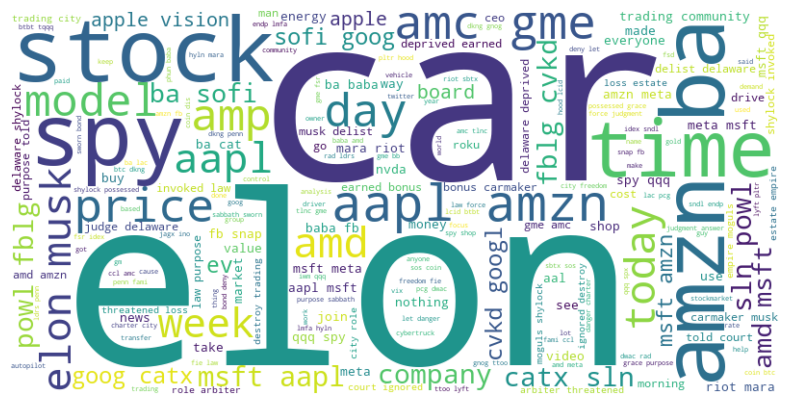

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(word_list):
    """Generate and display a word cloud from a list of words."""
    text = ' '.join(word_list)
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    
    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Assuming `all_keywords` is a list of all keywords extracted for a specific time frame
generate_word_cloud(all_keywords)


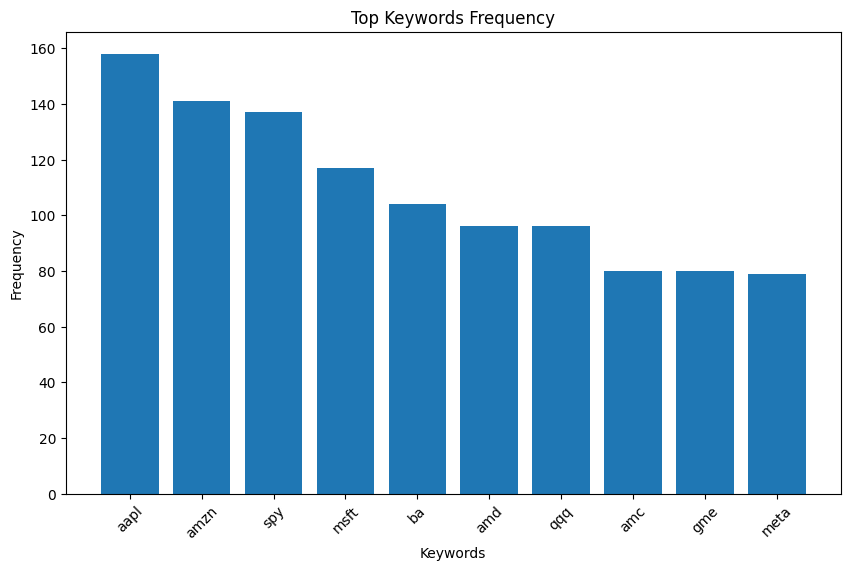

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_keyword_frequencies(keywords):
    """Plot a bar chart of keyword frequencies."""
    # Count the occurrences of each keyword
    counts = Counter(keywords)
    
    # Get the most common keywords and their counts
    common_keywords = counts.most_common(10)
    words, frequencies = zip(*common_keywords)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title('Top Keywords Frequency')
    plt.show()

# Example usage with a list of keywords
plot_keyword_frequencies(all_keywords)